# Identifying Bees Using Crowd Sourced Data using Amazon SageMaker 

### Table of contents
1. [Introduction to dataset](#introduction)
2. [Labeling with Amazon SageMaker Ground Truth](#groundtruth)
3. [Reviewing labeling results](#review)
4. [Training an Object Detection model](#training)
5. [Review of Training Results](#review_training)
6. [Model Tuning](#model_tuning)
7. [Cleanup](#cleanup)


<a name="introduction"></a>
## Introduction to dataset
We will use a dataset from the [inaturalist.org](inaturalist.org) This dataset contains 500 images of bees that have been uploaded by inaturalist users for the purposes of recording the observation and identification. We only used images that their users have licensed under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) license. For your convenience, we have placed the dataset in S3 in a single zip archive here: http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip

First, download and unzip the archive.

The archive contains the following structure: 500 `.jpg` image files, a manifest file (to be explained later) and 10 test images in the `test` subfolder.

Now let's upload this dataset to your own S3 bucket in preparation for labeling and training using Amazon SageMaker. For this demo, we will be using `us-west-2` region, so your bucket needs to be in this region. 

In [65]:
# S3 bucket must be created in us-west-2 (Oregon) region
BUCKET = 'bax-bees'
PREFIX = 'input' # this is the root path to your working space, feel to use a different path

In [66]:
!aws s3 sync  --include="[0-9]*.jpg"  s3://$BUCKET/$PREFIX/ baxbees

## Labeling with SageMaker Ground Truth <a name="groundtruth"></a>

Now, we are ready to run your first labeling with Amazon SageMaker Ground Truth. Follow the steps shown in the recording.

When specifying information needed to configure the labeling UI tool, use the following information:

- Brief task description: _"Draw a bounding box around the bee in this image."_
- Labels: _"bee"_
- Good example description: _"bounding box includes all visible parts of the insect - legs, antennae, etc."_
- Good example image: https://s3.us-west-2.amazonaws.com/aws-tc-largeobjects/DIG-TF-200-MLBEES-10-EN/bee-good-5535715.jpg
- Bad example description: _"bounding box is too big and/or excludes some visible parts of the insect"_
- Bad example image: https://s3.us-west-2.amazonaws.com/aws-tc-largeobjects/DIG-TF-200-MLBEES-10-EN/bee-bad-5535715.jpg

## Generating a manifest file for Amazon Sagemaker groundruth
<a name="reviewing"></a>

Amazon Sagemaker GroundTruth needs a manifest file with the location of all images in the S3 bucket. Using this file, Sagemaker GroundTruth generates a labelling job, the output of which will be the final augmented manifest file, which will have all bounding boxes labelled

In [67]:
import sagemaker
import boto3
from pathlib import Path
import pandas as pd
import json
import os

In [68]:
ROOT = Path('../s3')
MANIFEST_KEY = 'manifest/output.json'
MANIFEST_FILE = ROOT/MANIFEST_KEY

In [69]:
s3_data_path = '{}/{}'.format(BUCKET, PREFIX)
print(s3_data_path)

import datetime
import json

def datetime_handler(x):
    if isinstance(x, datetime.datetime):
        return x.isoformat()
    raise TypeError("Unknown type")



image_list = []

import boto3
client = boto3.client('s3')
response = client.list_objects(Bucket=BUCKET,Prefix=PREFIX)

for item in response['Contents']:
    json_object = json.dumps(item, default=datetime_handler)
    file_paths = os.path.basename(json.loads(json_object)['Key'])
    if file_paths is not '':
        image_list.append(file_paths)


df = pd.DataFrame(image_list)
df.head()
df.to_csv('image_list.csv', index =False, header = False)

bax-bees/input


## Reviewing labeling results
<a name="reviewing"></a>

After the labeling job has completed, we can see the results of image annotations right in the SageMaker console itself. The console displays each image as well as the bounding boxes around the bees that were drawn by human labelers.

At the same time we can examine the results in the so-called augmented manifest file that was generated. Let's download and examine the manifest file.

In [70]:
# Enter the name of your job here
labeling_job_name = 'bax-bees'

import boto3
client = boto3.client('sagemaker')

s3_output = client.describe_labeling_job(LabelingJobName=labeling_job_name)['OutputConfig']['S3OutputPath'] + labeling_job_name
augmented_manifest_url = f'{s3_output}/manifests/output/output.manifest'

import os
import shutil

# try:
#     os.makedirs('od_output_data/', exist_ok=False)
# except FileExistsError:
#     shutil.rmtree('od_output_data/')

# now download the augmented manifest file and display first 3 lines
!aws s3 cp $augmented_manifest_url ./
#augmented_manifest_file = 'od_output_data/output.manifest'
augmented_manifest_file = 'output.manifest'
!head -3 $augmented_manifest_file

download: s3://bax-bees/output/bax-bees/manifests/output/output.manifest to ./output.manifest
{"source-ref":"s3://bax-bees/input/10022723.jpg","bax-bees":{"image_size":[{"width":375,"height":500,"depth":3}],"annotations":[{"class_id":0,"top":201,"left":117,"height":174,"width":97}]},"bax-bees-metadata":{"objects":[{"confidence":0}],"class-map":{"0":"bee"},"type":"groundtruth/object-detection","human-annotated":"yes","creation-date":"2022-07-29T03:21:43.389678","job-name":"labeling-job/bax-bees"}}
{"source-ref":"s3://bax-bees/input/10059108.jpg","bax-bees":{"image_size":[{"width":375,"height":500,"depth":3}],"annotations":[{"class_id":0,"top":199,"left":125,"height":129,"width":150}]},"bax-bees-metadata":{"objects":[{"confidence":0}],"class-map":{"0":"bee"},"type":"groundtruth/object-detection","human-annotated":"yes","creation-date":"2022-07-29T03:18:54.559091","job-name":"labeling-job/bax-bees"}}
{"source-ref":"s3://bax-bees/input/10250726.jpg","bax-bees":{"image_size":[{"width":375,"

Now let's plot all the annotated images. First, let's define a function that displays the local image file and draws over it the bounding boxes obtained via labeling.

In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open('baxbees/' +img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Next, read the augmented manifest (JSON lines format) line by line and display the first 10 images.

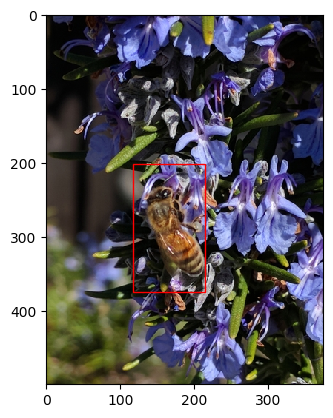

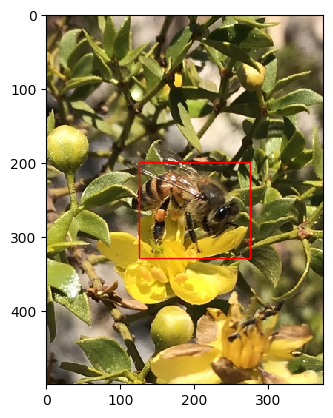

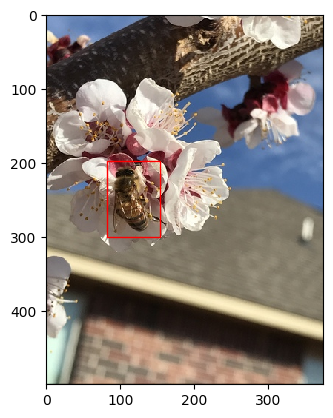

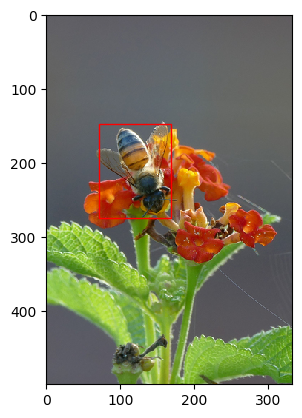

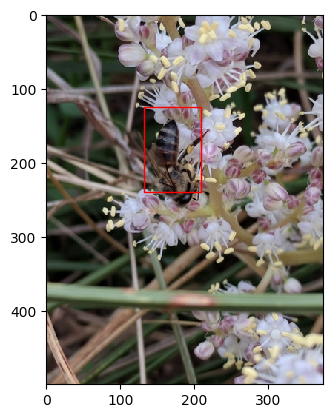

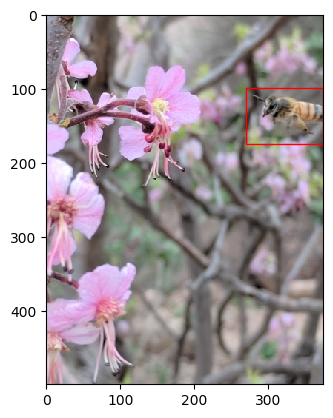

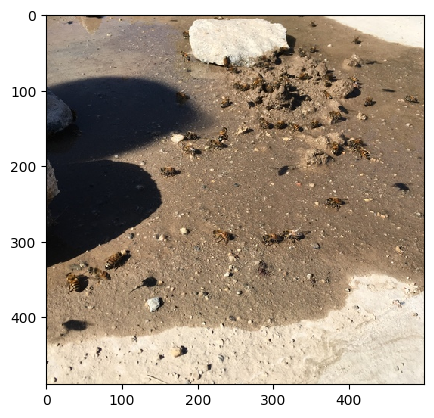

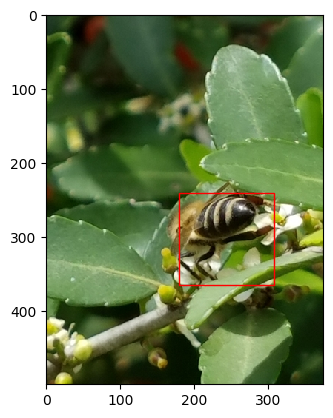

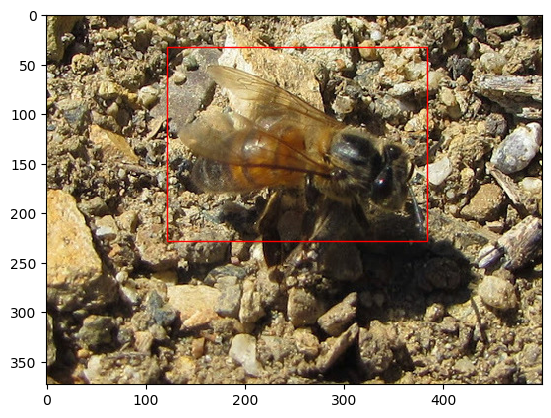

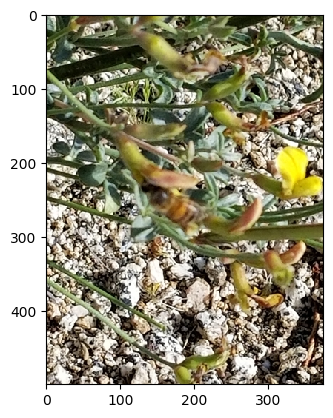

In [72]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines
from itertools import islice

with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        img_file = os.path.basename(img_url)
        file_exists = os.path.isfile(img_file)

        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes)

<a name='training'></a>
## Training an Object Detection Model
We are now ready to use the labeled dataset in order to train a Machine Learning model using the SageMaker [built-in Object Detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

For this, we would need to split the full labeled dataset into a training and a validation datasets. Out of the total of 500 images we are going to use 400 for training and 100 for validation. The algorithm will use the first one to train the model and the latter to estimate the accuracy of the model, trained so far. The augmented manifest file from the previously run full labeling job was included in the original zip archive as `output.manifest`.

In [73]:
import json

with jsonlines.open('output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 399, validation samples: 100


Next, let's upload the two manifest files to S3 in preparation for training. We will use the same bucket you created earlier.

In [74]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/

upload: ./train.manifest to s3://bax-bees/input/training/train.manifest
upload: ./validation.manifest to s3://bax-bees/input/training/validation.manifest


We are now ready to kick off the training. We will do it from the SageMaker console, but alternatively, you can just run this code in a new cell using SageMaker Python SDK:
### Code option


In [75]:
import time
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    boto3.Session().region_name, 'object-detection', repo_version='latest')
s3_output_path = 's3://{}/{}/output'.format(BUCKET, pfx_training)

# Create unique job name
training_job_name = 'baxbeestest'

training_params = \
    {
        "AlgorithmSpecification": {
            # NB. This is one of the named constants defined in the first cell.
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p2.xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": training_job_name,
        "HyperParameters": {  # NB. These hyperparameters are at the user's discretion and are beyond the scope of this demo.
            "base_network": "resnet-50",
            "use_pretrained_model": "1",
            "num_classes": "1",
            "mini_batch_size": "1",
            "epochs": "100",
            "learning_rate": "0.001",
            "lr_scheduler_step": "",
            "lr_scheduler_factor": "0.1",
            "optimizer": "sgd",
            "momentum": "0.9",
            "weight_decay": "0.0005",
            "overlap_threshold": "0.5",
            "nms_threshold": "0.45",
            "image_shape": "300",
            "label_width": "350",
            "num_training_samples": str(num_training_samples)
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_train_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": ['source-ref', 'bax-bees']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_validation_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": ['source-ref', 'bax-bees']
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            }
        ]
    }

# Now we create the SageMaker training job.
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

# Confirm that the training job has started
status = client.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Training job current status: InProgress


To check the progess of the training job, you can refresh the console or repeatedly evaluate the following cell. When the training job status reads `'Completed'`, move on to the next part of the tutorial.

In [98]:
##### REPLACE WITH YOUR OWN TRAINING JOB NAME
# In the above console screenshots the job name was 'bees-detection-resnet'.
# But if you used Python to kick off the training job,
# then 'training_job_name' is already set, so you can comment out the line below.
training_job_name = 'baxbeestest'
##### REPLACE WITH YOUR OWN TRAINING JOB NAME

training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])

Training job status:  Completed
Secondary status:  Completed


<a name='review_training'></a>

## Review of Training Results

First, let's create the SageMaker model out of model artifacts

In [99]:
import time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = training_job_name + '-model' + timestamp

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

from sagemaker import get_execution_role

role = get_execution_role()

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

s3://bax-bees/input/training/output/baxbeestest/output/model.tar.gz
arn:aws:sagemaker:us-east-1:567669566640:model/baxbeestest-model-2022-08-08-23-28-17


In [100]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: baxbeestest-epc-2022-08-08-23-28-24
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:567669566640:endpoint-config/baxbeestest-epc-2022-08-08-23-28-24


### Create Endpoint

The next cell creates an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [101]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = training_job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: baxbeestest-ep-2022-08-08-23-28-31
EndpointArn = arn:aws:sagemaker:us-east-1:567669566640:endpoint/baxbeestest-ep-2022-08-08-23-28-31


In [105]:
endpoint_name="baxbeestest-ep-2022-08-08-23-28-31"
# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

EndpointStatus = InService


### Perform inference

We will invoke the deployed endpoint to detect bees in the 10 test images that were inside the `test` folder in `dataset.zip` 

In [112]:
import glob
test_images = glob.glob('test/*')
print(*test_images, sep="\n")

test/1025450.jpg
test/10250726.jpg
test/10437385.jpg
test/10311147.jpg
test/10299519.jpg
test/9787032.jpg
test/10059108.jpg


Next, define a function that converts the prediction array returned by our endpoint to the bounding box structure expected by our image display function.

In [107]:
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

Finally, for each of the test images, the following cell transforms the image into the appropriate format for realtime prediction, repeatedly calls the endpoint, receives back the prediction, and displays the result.

test/9787032.jpg
test/9787032.jpg


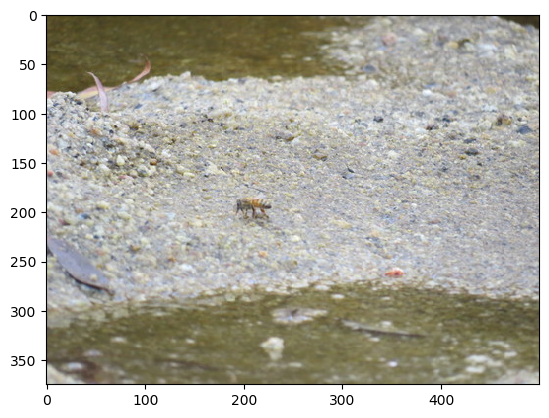

In [110]:
import matplotlib.pyplot as plt

runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    print(img_path)
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
        

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    print(test_image)
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .2
    best_n = 3
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

<a name='model_tuning'></a>
## Model Tuning

When you configured the training job you needed to add many hyperparameters that affect the performance of the algorithm and the quality of the resulting model. But how do you pick the right hyperparameters?

If you have experience with the specific algorithm and understand the innerworkings of it, you may already have a good sense of appropriate values. But even then, it's impossible to know the exact best value of each hyperparameter. Often you can zero in on the best values by trying many different combination of values, effectively searching in the hyperparameter space. SageMaker makes this extremely easy with the Model Tuning feature, also known as Hyperparameter Optimization (or HPO). With Model Tuning you simply decide which of the hyperparameters you are not sure about and specify the range of values for each that SageMaker needs to explore. Let's see again how this can be accomplished via the console.


<a name='cleanup'></a>
## Cleanup

At the end of the lab we would like to delete the real-time endpoint, as keeping a real-time endpoint around while being idle is costly and wasteful. 

In [ ]:
client.delete_endpoint(EndpointName=endpoint_name)